In [50]:
# cnn model
from numpy import mean
from numpy import std
import pandas as pd
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [51]:

filename="inertial data.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")

done


#data preprocessing

In [52]:

folder_path = "/content/inertial data/train"
file_names = os.listdir(folder_path)

# Sort file names to maintain consistent order
file_names.sort()

data_train = np.zeros((7352, 128, 9))

for i, file_name in enumerate(file_names):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for j, line in enumerate(lines):
            values = line.split()  # Split line into individual values
            features = [float(value) for value in values]  # Convert each value to float
            data_train[j, :, i] = np.array(features)

print(data_train.shape)

(7352, 128, 9)


In [53]:


csv_file = "/content/inertial data/y_train.csv"

y_train = pd.read_csv(csv_file, header=None)

In [54]:

folder_path = "/content/inertial data/test"
file_names = os.listdir(folder_path)

# Sort file names to maintain consistent order
file_names.sort()

data_test = np.zeros((2947, 128, 9))

for i, file_name in enumerate(file_names):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for j, line in enumerate(lines):
            values = line.split()  # Split line into individual values
            features = [float(value) for value in values]  # Convert each value to float
            data_test[j, :, i] = np.array(features)

print(data_test.shape)

(2947, 128, 9)


In [55]:


csv_file = "/content/inertial data/y_test.csv"

y_test= pd.read_csv(csv_file, header=None)

In [56]:
print(len(y_test))

2947


In [57]:
y_train=y_train-1
y_test=y_test-1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [58]:
print(y_train.shape[1])

6


In [59]:


def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size


def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')



#Cnn model

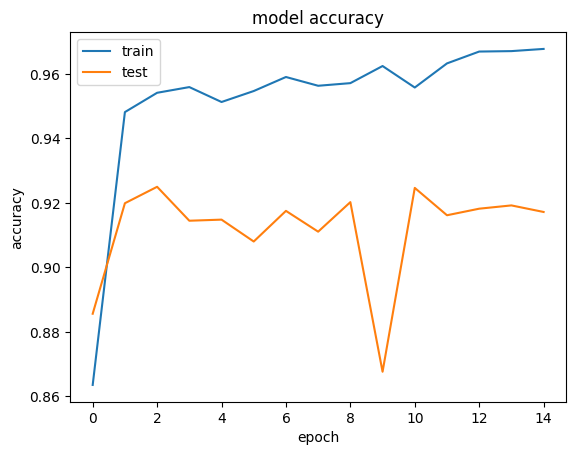

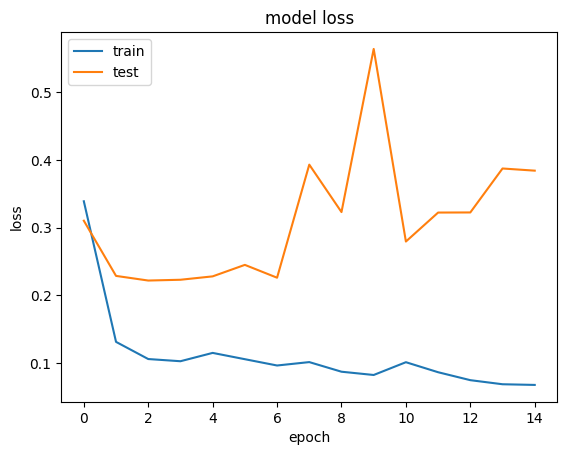

0.917203962802887


In [60]:
import matplotlib.pyplot as plt



epochs, batch_size =15, 32
n_timesteps, n_features, n_outputs = 128,9,6
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(data_train, y_train,validation_data=(data_test,y_test), epochs=epochs, batch_size=batch_size, verbose=0)

_, accuracy = model.evaluate(data_test, y_test, batch_size=batch_size, verbose=0)








plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(accuracy)


In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 123, 64)           3520      
                                                                 
 conv1d_3 (Conv1D)           (None, 118, 64)           24640     
                                                                 
 dropout_2 (Dropout)         (None, 118, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 59, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3776)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               377700    
                                                      

93/93 [==============================] - 0s 2ms/step


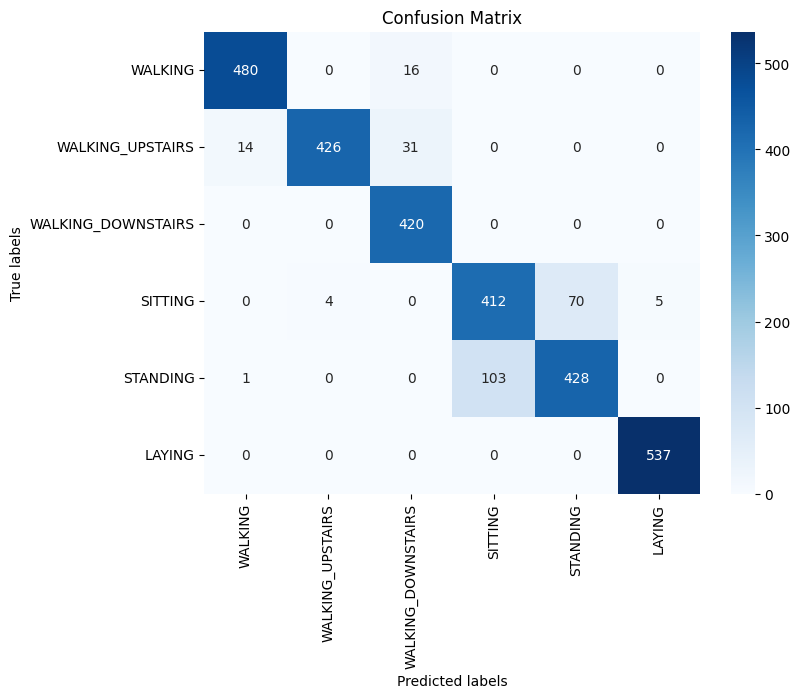

In [62]:
y_pred = model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
# Define class labels (if you have them, otherwise it will be numbered 0, 1, 2, ...)
class_labels = ['WALKING',
'WALKING_UPSTAIRS',
'WALKING_DOWNSTAIRS',
'SITTING','STANDING','LAYING'
]
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()




saving model and size used

In [63]:
KERAS_MODEL_NAME = "tf_model.h5"
model.save(KERAS_MODEL_NAME)
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")



File size: 4.694 Megabytes


converting to tflite float32

In [64]:
# converting to tenserflow lite
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()





In [65]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

1630768

In [66]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")
print("OR")
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File size: 1592.547 Kilobytes
OR
File size: 1.555 Megabytes


In [67]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

In [68]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 128   9]
Input Type: <class 'numpy.float32'>
Output Shape: [1 6]
Output Type: <class 'numpy.float32'>


In [69]:


interpreter.resize_tensor_input(input_details[0]['index'], (2947, 128, 9))
interpreter.resize_tensor_input(output_details[0]['index'], (2947, 6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])



Input Shape: [2947  128    9]
Input Type: <class 'numpy.float32'>
Output Shape: [2947    6]
Output Type: <class 'numpy.float32'>


In [70]:
data_test.dtype

dtype('float64')

In [71]:
test_numpy = np.array(data_test, dtype=np.float32)# to convert it from float64 to float 32

In [72]:
test_numpy.dtype

dtype('float32')

In [73]:
interpreter.set_tensor(input_details[0]['index'], test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (2947, 6)


In [74]:
print(prediction_classes)

[4 4 4 ... 1 1 1]


In [75]:
prediction_classes = to_categorical(prediction_classes)

In [76]:
print(prediction_classes)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [77]:
print(y_test)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [78]:
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 91.72%


float16

In [80]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 799.816 Kilobytes


In [81]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FLOAT_16_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 128   9]
Input Type: <class 'numpy.float32'>
Output Shape: [1 6]
Output Type: <class 'numpy.float32'>


In [82]:
interpreter.resize_tensor_input(input_details[0]['index'], (2947, 128, 9))
interpreter.resize_tensor_input(output_details[0]['index'], (2947, 6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [2947  128    9]
Input Type: <class 'numpy.float32'>
Output Shape: [2947    6]
Output Type: <class 'numpy.float32'>


In [83]:
test_numpy = np.array(data_test, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (2947, 6)


In [84]:
prediction_classes = to_categorical(prediction_classes)

In [85]:
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 91.72%


further reduction to the most optimal size

In [86]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [87]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 405.789 Kilobytes


In [88]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [89]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 128   9]
Input Type: <class 'numpy.float32'>
Output Shape: [1 6]
Output Type: <class 'numpy.float32'>


In [90]:
interpreter.resize_tensor_input(input_details[0]['index'], (2947, 128, 9))
interpreter.resize_tensor_input(output_details[0]['index'], (2947, 6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [2947  128    9]
Input Type: <class 'numpy.float32'>
Output Shape: [2947    6]
Output Type: <class 'numpy.float32'>


In [91]:
test_numpy = np.array(data_test, dtype=np.float32)

In [92]:
interpreter.set_tensor(input_details[0]['index'], test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (2947, 6)


In [93]:
prediction_classes = to_categorical(prediction_classes)

In [94]:
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 91.79%


#RNN model

In [95]:
 # define model

trainX,testX,trainy,testy=data_train, data_test,y_train,y_test
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = 128,9,6
 # reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
 # define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

In [96]:
print(accuracy)

0.9009161591529846


optimization

In [97]:
# TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"
# tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = tf_lite_converter.convert()
TF_LITE_MODEL_FILE_NAME = "tf_lite_model_lstm.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
# Convert the model to TensorFlow Lite format



ConverterError: ignored

In [ ]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

In [ ]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (2947, 128, 9))
interpreter.resize_tensor_input(output_details[0]['index'], (2947, 6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
test_numpy = np.array(data_test, dtype=np.float32)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

In [ ]:
prediction_classes = to_categorical(prediction_classes)
acc = accuracy_score(prediction_classes, y_test)
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

In [ ]:
model="/content/tf_model.h5"
model.summary()